In [1]:
%matplotlib inline

import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk import download
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../data/train.tsv', sep='\t')
print("Number of items: {}".format(len(df)))
df.head()

Number of items: 1482535


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
df = df[:200000] # I need the power!

In [4]:
price = df["price"]
price.describe().apply(lambda x: format(x, 'f'))

count    200000.000000
mean         26.744937
std          38.724400
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        1909.000000
Name: price, dtype: object

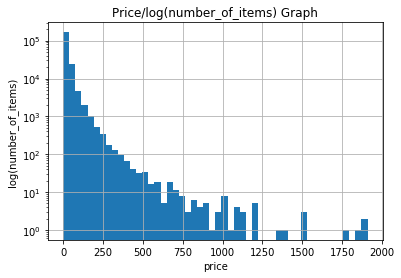

In [5]:
price.hist(log=True, bins=50)
plt.title("Price/log(number_of_items) Graph")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()

In [6]:
zeros = np.where(price==0)
print("Number of free items: {}".format(zeros[0].size))

Number of free items: 106


In [7]:
category_counts = df["category_name"].value_counts()
print("Most frequent categories:")
category_counts.head(20)

Most frequent categories:


Women/Athletic Apparel/Pants, Tights, Leggings                 8003
Women/Tops & Blouses/T-Shirts                                  6218
Beauty/Makeup/Face                                             4643
Beauty/Makeup/Lips                                             4076
Electronics/Video Games & Consoles/Games                       3484
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    3388
Beauty/Makeup/Eyes                                             3384
Women/Underwear/Bras                                           2985
Women/Tops & Blouses/Tank, Cami                                2774
Women/Tops & Blouses/Blouse                                    2761
Women/Dresses/Above Knee, Mini                                 2712
Women/Jewelry/Necklaces                                        2686
Women/Athletic Apparel/Shorts                                  2664
Beauty/Makeup/Makeup Palettes                                  2638
Beauty/Fragrance/Women                          

In [8]:
def first_level_cat(x):
    p = re.compile("[^/]*")
    try:
        return p.match(x).group()
    except TypeError:
        return "None"

categories = df.copy(deep=True)
first_level_categories = categories["category_name"].apply(first_level_cat)
first_level_category_counts = first_level_categories.value_counts()
print("Most frequent first-level categories:")
first_level_category_counts.head(20)

Most frequent first-level categories:


Women                     89875
Beauty                    28075
Kids                      23123
Electronics               16455
Men                       12699
Home                       9102
Vintage & Collectibles     6209
Other                      6122
Handmade                   4119
Sports & Outdoors          3369
None                        852
Name: category_name, dtype: int64

In [9]:
brand_counts = df["brand_name"].value_counts()
print("Most frequent brands:")
brand_counts.head(20)

Most frequent brands:


PINK                 7368
Nike                 7201
Victoria's Secret    6522
LuLaRoe              4241
Apple                2367
Nintendo             2029
FOREVER 21           2026
Lululemon            1978
Michael Kors         1839
American Eagle       1805
Rae Dunn             1652
Sephora              1615
Coach                1420
Adidas               1398
Bath & Body Works    1339
Disney               1328
Funko                1257
Under Armour         1129
Sony                 1071
Old Navy             1026
Name: brand_name, dtype: int64

In [10]:
item_condition = df["item_condition_id"]
print("Item conditions:")
print("1: new\n2: like new\n3: good\n4: fair\n5: poor")
print("-----------------------")
print("Item condition counts:")
item_condition.value_counts()

Item conditions:
1: new
2: like new
3: good
4: fair
5: poor
-----------------------
Item condition counts:


1    86222
3    58301
2    50875
4     4264
5      338
Name: item_condition_id, dtype: int64

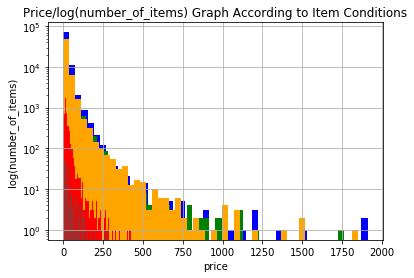

blue: new
green: like new
orange: good
red: fair
brown: poor


In [11]:
condition_colors = ['blue', 'green', 'orange', 'red', 'brown']
for i, color in enumerate(condition_colors):
    plot_df = df.query('item_condition_id == {}'.format(i+1))
    plot_df['price'].hist(log=True, color=color, bins=50)
plt.title("Price/log(number_of_items) Graph According to Item Conditions")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()
print("blue: new\ngreen: like new\norange: good\nred: fair\nbrown: poor")

In [12]:
shipping_status = df["shipping"]
print("Shipping statuses:")
print("1: paid shipping\n2: non-paid shipping")
print("-----------------------")
print("Shipping status counts:")
shipping_status.value_counts()

Shipping statuses:
1: paid shipping
2: non-paid shipping
-----------------------
Shipping status counts:


0    110596
1     89404
Name: shipping, dtype: int64

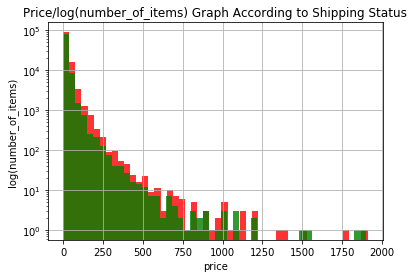

green: paid shipping
red: non-paid shipping


In [13]:
condition_colors = ['red', 'green']
for i, color in enumerate(condition_colors):
    plot_df = df.query('shipping == {}'.format(i))
    plot_df['price'].hist(log=True, color=color, bins=50, alpha=0.8)
plt.title("Price/log(number_of_items) Graph According to Shipping Status")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()
print("green: paid shipping\nred: non-paid shipping")

In [14]:
def price_median(x, limit=0):
    return x["price"].median() if len(x) > limit else 0

expensives = df.copy(deep=True)
expensive_brands = expensives.groupby(['brand_name'])
print("Most expensive brands according to price mean:")
expensive_brands.apply(price_median).sort_values(ascending=False).head(20)

Most expensive brands according to price mean:


brand_name
Sanyo                  874.0
Céline                 457.5
Chloé                  368.5
Samsung Galaxy         276.0
Terani Couture         259.0
Vitamix                252.5
Derek Lam              244.0
David Yurman           225.5
Alexander Wang         224.0
Tag Heuer              219.0
Mackintosh             209.5
GoPro                  208.0
Celine                 204.5
Alyce Paris            200.0
Bottega Veneta         185.5
Mac Duggal             182.0
Rihanna                181.0
Giuseppe Zanotti       173.0
Saint Laurent          170.5
Christian Louboutin    166.0
dtype: float64

In [15]:
limit = 1000
print("Most expensive and popular (having at least {} items listed) brands according to price mean:".format(limit))
expensive_brands.apply(lambda x: price_median(x, limit=limit)).sort_values(ascending=False).head(20)

Most expensive and popular (having at least 1000 items listed) brands according to price mean:


brand_name
Michael Kors         47.0
Lululemon            39.0
Coach                31.0
Rae Dunn             31.0
LuLaRoe              29.0
Adidas               25.0
Nike                 22.0
Funko                21.0
Apple                21.0
Sony                 20.0
PINK                 20.0
Nintendo             20.0
Victoria's Secret    19.0
Under Armour         16.0
Sephora              16.0
Bath & Body Works    15.0
American Eagle       14.0
Disney               13.0
FOREVER 21           12.0
Old Navy             11.0
dtype: float64

In [16]:
expensive_categories = df.groupby(['category_name'])
print("Most expensive categories according to price mean:")
expensive_categories.apply(price_median).sort_values(ascending=False).head(20)

Most expensive categories according to price mean:


category_name
Vintage & Collectibles/Antique/Furniture                         195.0
Vintage & Collectibles/Bags and Purses/Formal                    159.0
Kids/Strollers/Standard                                          150.0
Electronics/Cameras & Photography/Flashes & Flash Accessories    141.0
Other/Musical instruments/DJ, Electronic Music & Karaoke         110.0
Home/Kids' Home Store/Nursery Bedding                            109.0
Vintage & Collectibles/Trading Cards/Comic                       107.0
Home/Home Appliances/Air Conditioners                            103.5
Electronics/Computers & Tablets/Laptops & Netbooks                95.0
Kids/Strollers/Travel Systems                                     95.0
Other/Musical instruments/Bass Guitars                            92.0
Women/Women's Handbags/Satchel                                    91.0
Handmade/Dolls and Miniatures/Fantasy                             89.0
Home/Furniture/Home Entertainment Furniture                    

In [17]:
print("Most expensive first-level categories according to price mean:")
categories.groupby(first_level_categories).apply(price_median).sort_values(ascending=False).head(20)

Most expensive first-level categories according to price mean:


category_name
Men                       21.0
Women                     19.0
None                      18.0
Home                      18.0
Sports & Outdoors         17.0
Vintage & Collectibles    16.0
Electronics               15.0
Beauty                    15.0
Kids                      14.0
Other                     13.0
Handmade                  12.0
dtype: float64

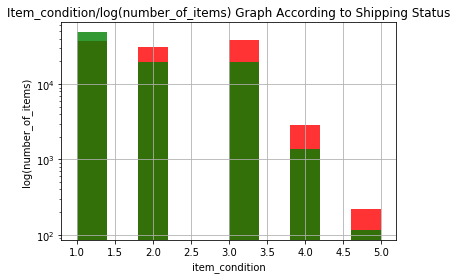

green: paid shipping
red: non-paid shipping
-----------------------
1: new
2: like new
3: good
4: fair
5: poor


In [18]:
condition_colors = ['red', 'green']
for i, color in enumerate(condition_colors):
    plot_df = df.query('shipping == {}'.format(i))
    plot_df['item_condition_id'].hist(log=True, color=color, alpha=0.8)
plt.title("Item_condition/log(number_of_items) Graph According to Shipping Status")
plt.xlabel("item_condition")
plt.ylabel("log(number_of_items)")
plt.show()
print("green: paid shipping\nred: non-paid shipping")
print("-----------------------")
print("1: new\n2: like new\n3: good\n4: fair\n5: poor")

In [19]:
download("stopwords")
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/ihsan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
descriptions = df.copy(deep=True)
descriptions = descriptions.dropna(subset=["item_description"], how="any")
word_list = " ".join(descriptions["item_description"]).lower().split()
print("Most frequent words inside item descriptions excluding stop words:")
pd.Series([x if x not in stop_words else None for x in word_list]).value_counts()[:20]

Most frequent words inside item descriptions excluding stop words:


size         53547
new          52315
brand        33662
free         32071
[rm]         22997
never        21231
-            20818
shipping     19591
worn         19513
great        19358
used         18607
&            16802
black        16732
price        16064
condition    15717
one          14813
2            14728
like         14413
please       14084
bundle       13698
dtype: int64